In [78]:
%matplotlib inline

In [79]:
from pylab import *
import pylab
import matplotlib as mpl
import numpy
import lnm
from graph import Graph
import ipywidgets as widgets
from IPython.display import display, HTML
mpl.rcParams['savefig.dpi'] = 150
OPTIONS = {'FSM (HEAD)': 'results_fsm_head.txt',
           'KCFA (6.2.1)': 'results_kcfa_6_2_1.txt',
           'KCFA (HEAD)': 'results_kcfa_head.txt',
           'Morse Code (HEAD)': 'results_morse-code_head.txt',
           'Snake (HEAD)': 'results_snake_head.txt',
           'Snake (6.2.1)': 'results_snake_6_2_1.txt',
           'Tetris (6.2.1)': 'results_tetris_6_2_1.txt',
           'Tetris (HEAD)': 'results_tetris_head.txt',
           'Sieve (6.2.1)': 'results_sieve_6_2_1.txt',
           'Sieve (HEAD)': 'results_sieve_head.txt',
           'Suffix Tree (6.2.1)': 'results_suffixtree_6_2_1.txt',
           'Suffix Tree (HEAD)': 'results_suffixtree_head.txt',
           'Synth (HEAD)':'results_synth_head.txt',
           'Synth (6.2.1)': 'results_synth_6_2_1.txt'}
s = widgets.Dropdown(options=OPTIONS)
all_data_files = ['results_fsm_head.txt',
                  'results_morse-code_head.txt',
                  'results_snake_head.txt',
                  'results_tetris_head.txt',
                  'results_sieve_head.txt',
                  'results_kcfa_head.txt',
                  'results_suffixtree_head.txt',
                  'results_synth_head.txt']
def strip_name(name):
    return name.rpartition("_")[0].partition("_")[2]

In [97]:
display(s)

In [98]:
benchmark = strip_name(s.value)
HTML("<h1>Benchmark: '" + benchmark + "'</h1>")

# Select Benchmark:

In [99]:
graph = lnm.read_data(s.value)
variations, data = graph.ungraph()
hidden_untyped = data[0,2]
pycket_untyped = data[0,1]
racket_untyped = data[0,0]
hidden = data[:,2]
pycket = data[:,1]
racket = data[:,0]

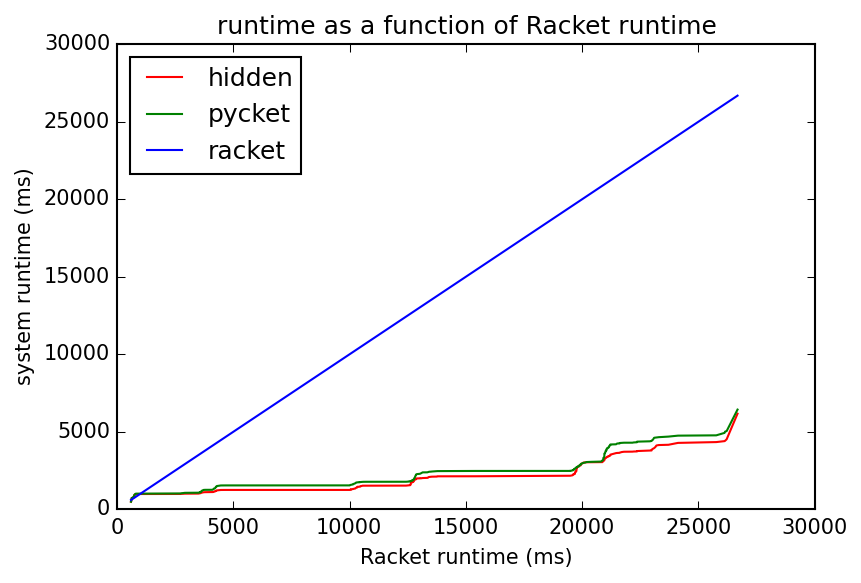

In [100]:
# Runtime of Pycket as a function of Racket
ordered_data = np.copy(data)
ordered_data.sort(axis=0)
ohidden = ordered_data[:,2]
opycket = ordered_data[:,1]
oracket = ordered_data[:,0]
pylab.plot(oracket, ohidden, 'r', label='hidden')
pylab.plot(oracket, opycket, 'g', label='pycket')
pylab.plot(oracket, oracket, 'b', label='racket')
pylab.title('runtime as a function of Racket runtime')
pylab.xlabel('Racket runtime (ms)')
pylab.ylabel('system runtime (ms)')
pylab.legend(loc='best')

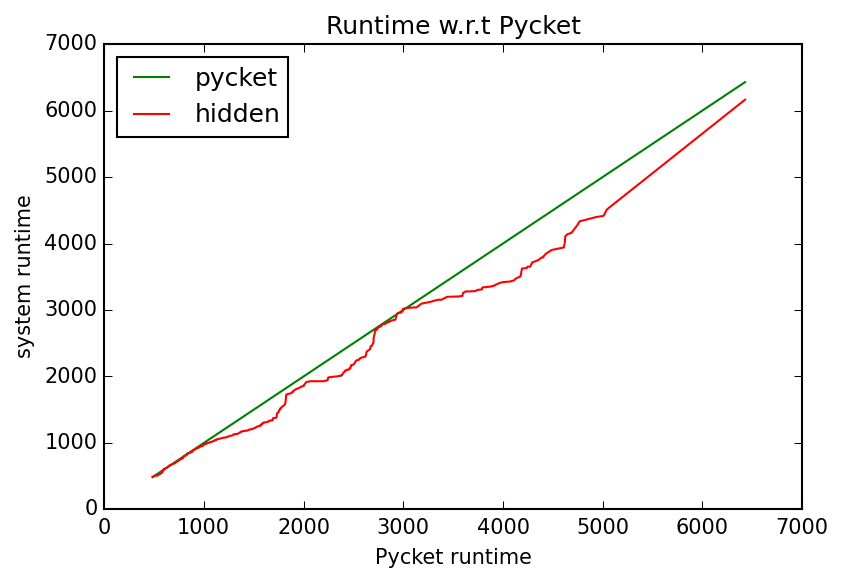

In [101]:
pylab.plot(opycket, opycket, 'g', label='pycket')
pylab.plot(opycket, ohidden, 'r', label='hidden')
pylab.title('Runtime w.r.t Pycket')
pylab.xlabel('Pycket runtime')
pylab.ylabel('system runtime')
pylab.legend(loc='best')

In [116]:
from scipy.stats import cumfreq
from pandas      import DataFrame
from ipy_table   import *

hidden_slowdown = hidden / float(hidden_untyped)
pycket_slowdown = pycket / float(pycket_untyped)
racket_slowdown = racket / float(racket_untyped)

def make_slowdown_data(fname):
    data = np.genfromtxt(fname, usecols=(1,2,3))
    hidden_untyped = float(data[0,2])
    pycket_untyped = float(data[0,1])
    racket_untyped = float(data[0,0])
    hidden = data[:,2]
    pycket = data[:,1]
    racket = data[:,0]
    weights = np.ones(len(hidden)) / float(len(hidden))
    return racket / racket_untyped, pycket / pycket_untyped, hidden / hidden_untyped, weights

def compute_deliverable(data):
    th = sum(data < 3)
    oh = sum(numpy.logical_and(data >= 3, data < 10))
    return [max(data), numpy.mean(data), np.median(data), "%d (%0.2f%%)" % (th, th / float(len(data)) * 100), "%d (%0.2f%%)" % (oh, oh / float(len(data)) * 100)]

def make_deliverable_table(**kwargs):
    lst = [["", "Max overhead", "Mean overhead", "Median overhead", "300-deliverable", "300/1000-usable"]]
    for name, data in kwargs.iteritems():
        lst.append([name] + compute_deliverable(data))
    tbl = make_table(map(list, zip(*lst)))
    apply_theme('basic_both')
    return tbl

def slowdown_cdf(*args, **kwargs):
    weights = kwargs.get('weights', None)
    many_weights = kwargs.get('many_weights', None)
    entries = 0   

    for i, (data, color, label) in enumerate(args):
        if weights is not None:
            counts, bin_edges = numpy.histogram(data, weights=weights, bins=len(data))
            entries = np.sum(weights)
        elif many_weights is not None:
            counts, bin_edges = numpy.histogram(data, weights=many_weights[i], bins=len(data))
            entries = np.sum(many_weights[i])
        else:
            counts, bin_edges = numpy.histogram(data, bins=len(data))
            entries = len(data)
        cdf = numpy.cumsum(counts)
        if not color:
            pylab.plot(bin_edges[:-1], cdf, label=label)
        else:
            pylab.plot(bin_edges[:-1], cdf, color=color, label=label)
    fname = "slowdown_{name}.pdf".format(**kwargs)
    pylab.axvline(3, color='y')
    pylab.axvline(10, color='k')
    pylab.axhline(len(data) * 0.6, color='c', ls='--')
    pylab.xlabel('slowdown factor')
    pylab.xlim((1,20))
    pylab.ylim((0,entries))
    pylab.ylabel('number below')
    pylab.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    pylab.savefig(fname)
    
def compute_lnm_deliverable(slowdown_graph, L):
    graph = lnm.compute_lnm_times(slowdown_graph, L)
    data = graph.ungraph()[1]
    rs = data[:,0]
    ps = data[:,1]
    hs = data[:,2]
    return rs, ps, hs, make_deliverable_table(racket=rs, pycket=ps,hidden=hs)
    
rs_, ps_, hs_, weights_ = zip(*[make_slowdown_data(fname) for fname in all_data_files])
rs = reduce(np.append, rs_)
ps = reduce(np.append, ps_)
hs = reduce(np.append, hs_)
weights = reduce(np.append, weights_)
print weights.shape, rs.shape, ps.shape, hs.shape

(2036,) (2036,) (2036,) (2036,)


# All Data

## All Benchmarks for Hidden

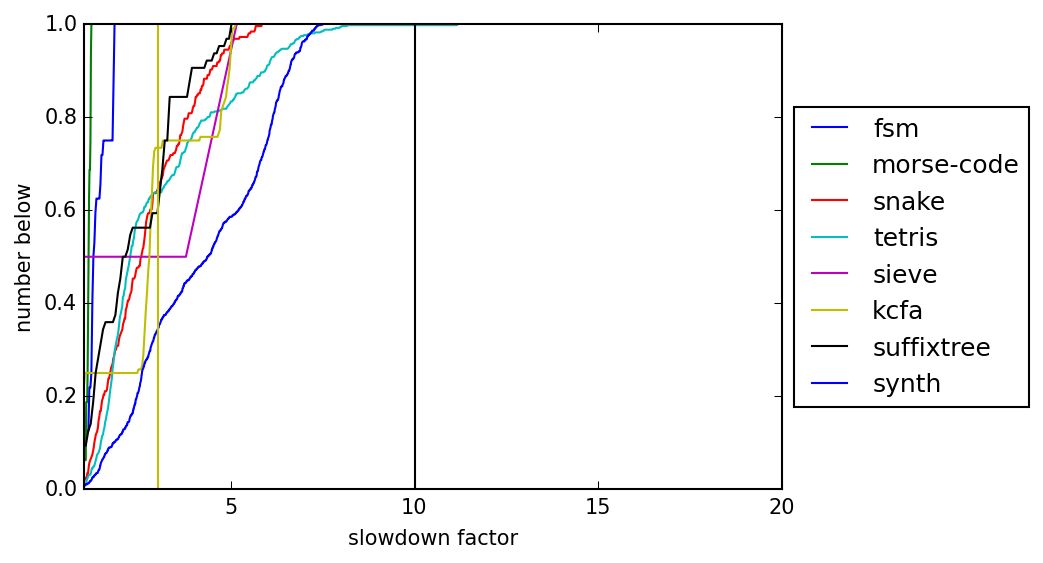

In [117]:
slowdown_cdf(*[(arr, None, strip_name(name)) for arr, name in zip(hs_, all_data_files)],
            name="name",
            many_weights=weights_)

## All Benchmarks for Pycket

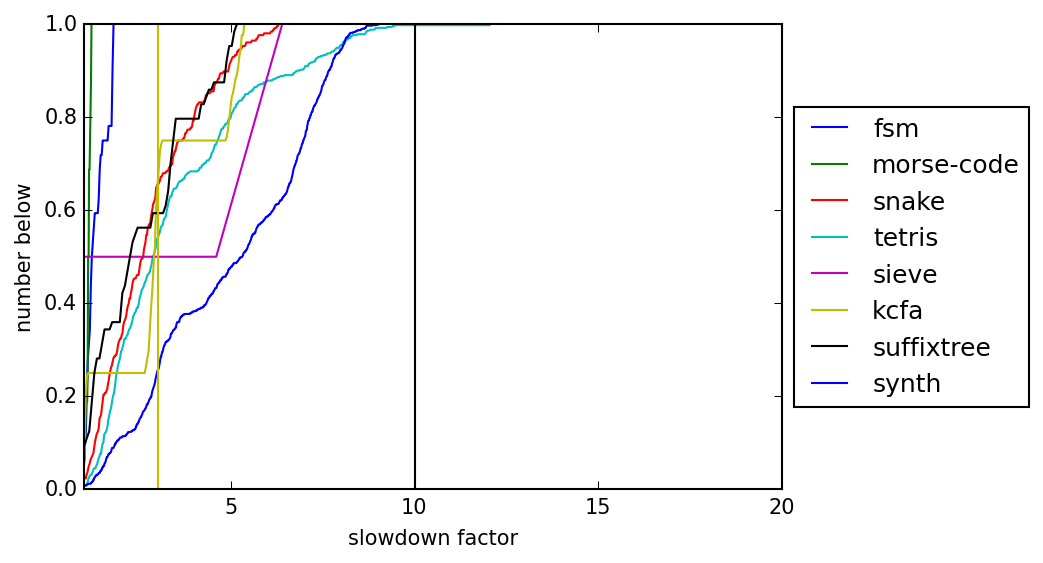

In [118]:
slowdown_cdf(*[(arr, None, strip_name(name)) for arr, name in zip(ps_, all_data_files)],
            name="name",
            many_weights=weights_)

## All Benchmarks for Racket

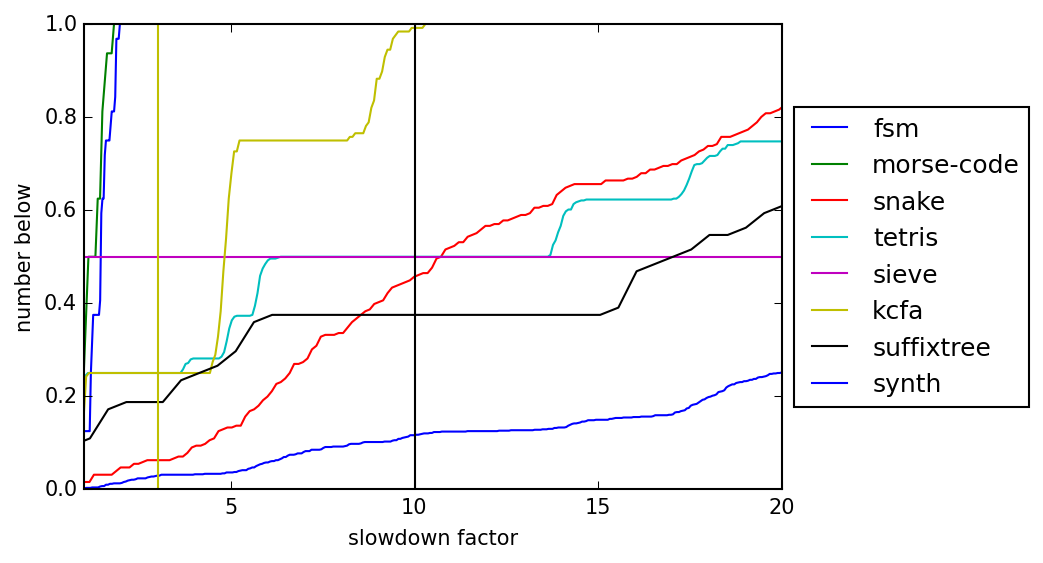

In [119]:
slowdown_cdf(*[(arr, None, strip_name(name)) for arr, name in zip(rs_, all_data_files)],
            name="name",
            many_weights=weights_)

(2036,) (2036,)


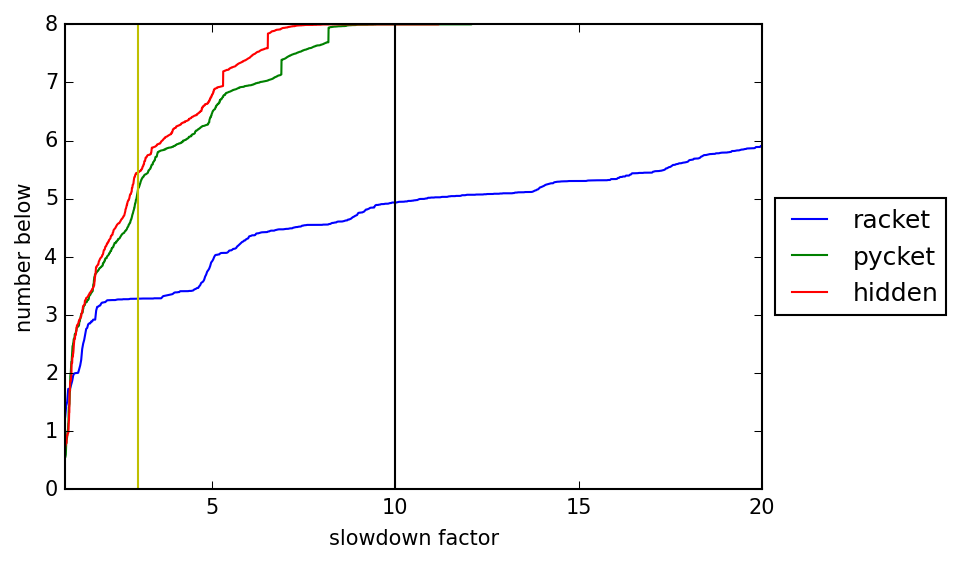

In [120]:
print hs.shape, weights.shape
slowdown_cdf((rs, 'b', 'racket'),
             (ps, 'g', 'pycket'),
             (hs, 'r', 'hidden'),
             weights=weights,
             name="all_data")

# Slowdown Summary Stats

In [121]:
DataFrame({'racket':racket, 'pycket':pycket, 'hidden':hidden}).describe()

,hidden,pycket,racket
count,512.000000,512.000000,512.000000
mean,1660.882812,1852.578125,9270.601562
std,947.312928,1069.824655,7882.886134
min,487.000000,484.000000,596.000000
25%,983.000000,1012.250000,2227.000000
50%,1246.000000,1539.000000,7336.000000
75%,2136.250000,2471.500000,16418.000000
max,6166.000000,6430.000000,26684.000000


# Deliverability Stats

## L = 0

In [122]:
slowdown_graph = lnm.fromkeyvals(variations, racket_slowdown, pycket_slowdown, hidden_slowdown)
racket_slowdown0, pycket_slowdown0, hidden_slowdown0, tbl = compute_lnm_deliverable(slowdown_graph, 0)
tbl

,racket,hidden,pycket
Max overhead,36.6538,11.1906,12.0865
Mean overhead,12.7343,3.0143,3.4823
Median overhead,10.0769,2.2613,2.8929
300-deliverable,128 (25.00%),327 (63.87%),274 (53.52%)
300/1000-usable,128 (25.00%),184 (35.94%),237 (46.29%)


## L = 1

In [123]:
racket_slowdown1, pycket_slowdown1, hidden_slowdown1, tbl = compute_lnm_deliverable(slowdown_graph, 1)
tbl

,racket,hidden,pycket
Max overhead,14.0659,3.8149,4.6673
Mean overhead,3.4867,1.6677,1.8272
Median overhead,1.0110,1.6642,1.7462
300-deliverable,320 (62.50%),501 (97.85%),497 (97.07%)
300/1000-usable,128 (25.00%),11 (2.15%),15 (2.93%)


## L = 2

In [124]:
racket_slowdown2, pycket_slowdown2, hidden_slowdown2, tbl = compute_lnm_deliverable(slowdown_graph, 2)
tbl

,racket,hidden,pycket
Max overhead,1.0934,2.1815,2.2763
Mean overhead,0.8953,1.3315,1.4034
Median overhead,0.8516,1.3031,1.3590
300-deliverable,512 (100.00%),512 (100.00%),512 (100.00%)
300/1000-usable,0 (0.00%),0 (0.00%),0 (0.00%)


# Slowdown distribution

## L = 0

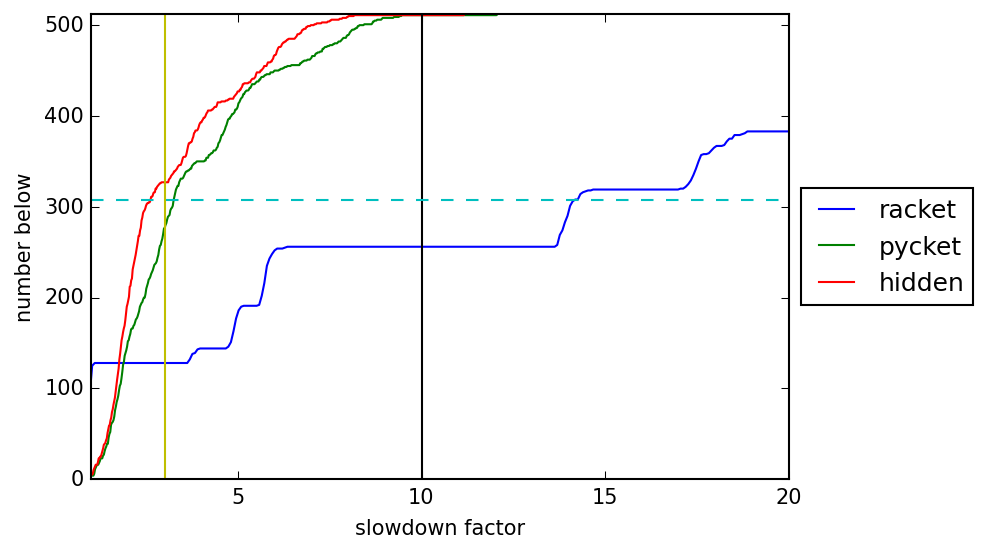

In [125]:
slowdown_cdf((racket_slowdown0, 'b', 'racket'),
             (pycket_slowdown0, 'g', 'pycket'),
             (hidden_slowdown0, 'r', 'hidden'),
             name="%s_l=0" % benchmark)

## L = 1

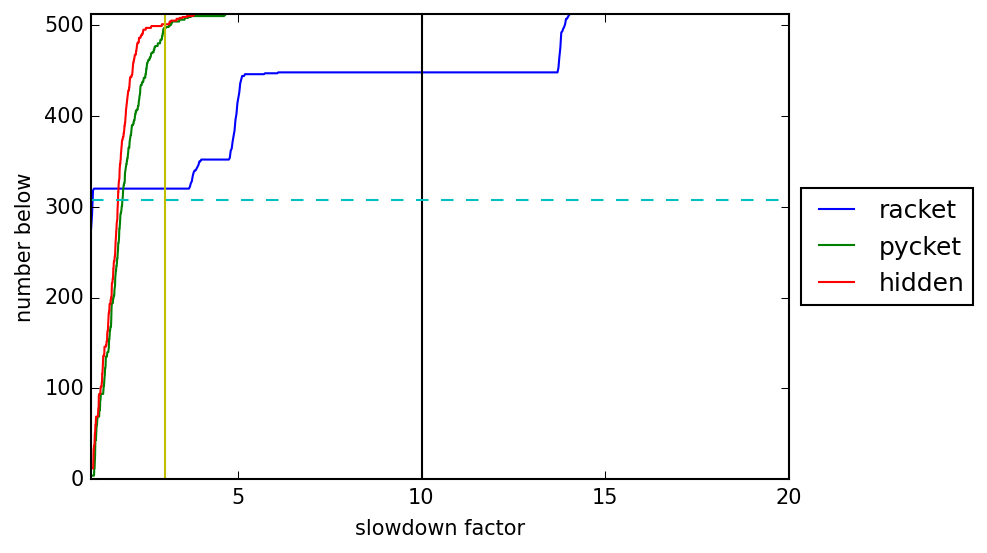

In [126]:
slowdown_cdf((racket_slowdown1, 'b', 'racket'),
             (pycket_slowdown1, 'g', 'pycket'),
             (hidden_slowdown1, 'r', 'hidden'),
             name="%s_l=1" % benchmark)

## L = 2

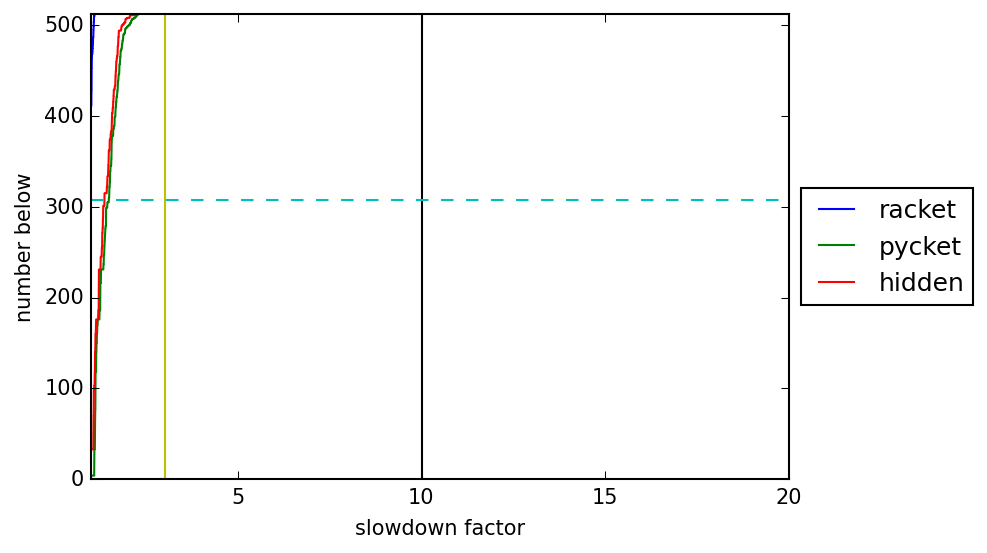

In [127]:
slowdown_cdf((racket_slowdown2, 'b', 'racket'),
             (pycket_slowdown2, 'g', 'pycket'),
             (hidden_slowdown2, 'r', 'hidden'),
             name="%s_l=2" % benchmark)